# The relationship between Airbnb density and crime at MSOA Level in London

## CASA0013: Foundations of Spatial Data Science

### Student Ids: zczltsu, ucfnhpr, ucbq793, ucfnuoc



This python notebook is intended to provide a reproducable analysis for the data and policy briefing.  
It includes codes from the practical files in repositories from the following modules offered in CASA
- CASA0013 Foundations of Spatial Data Science (https://github.com/jreades/fsds/tree/master/practicals)
- CASA0007 Quantitative Methods (ttps://github.com/huanfachen/QM_2021/tree/main/practicals)

Datasets to be used for this analysis
- MSOA Boundaries in UK (https://geoportal.statistics.gov.uk/datasets/ons::middle-layer-super-output-areas-dec-2011-boundaries-full-extent-bfe-ew-v3/explore?location=52.800669%2C-2.487024%2C6.93)  
- Airbnb data from Inside Airbnb (http://insideairbnb.com/get-the-data) (external link provided) - Independent Variable   
Data has been last scraped on 10 September 2022. 
- Crime data from data.police.uk (https://data.police.uk/data/) (uploaded on github)- Dependent variable   
zipfile including City of London police service and Metropolitan Police Service crime records at LSOA level between July and November 2022. Retrived from 
- MSOA Atlas from Greater London Authority (https://data.london.gov.uk/dataset/msoa-atlas) (direct link) - Control variables  
'provides a summary of demographic and related data for each Middle Super Output Area in Greater London'
- Geographic look up for London from Greater London Authority (uploaded on github)(https://www.data.gov.uk/dataset/c9ff8974-a204-4f20-964b-42907ce508ca/geographic-lookups-for-london)    
for identifying MSOAs and scaling between different geographic scales
- MSOA Population Estimate from Greater London Authority (https://www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/populationestimates/datasets/middlesuperoutputareamidyearpopulationestimates) (uplooaded on github)
For the most updated data (although estimates) on MSOA population. We have used the most recent (mid-2020) data.  

### Table in policy briefing

| **Variables** | **Source** | **Explanation of variable** |
|---------|-----|------|
| **Dependent Variables**   ||
|  Crime rate       |  Data.police.uk  |  The total number of crimes reported to the Metropolitan Police Service and City of London Police between July and September 2022 crimes* per 1000 people *categories of crime = anti-social behavior and drugs |
| **Independent Variable**  ||
|  Airbnb density       |  Inside Airbnb  |  The total number of Airbnbs identified as of 10 September 2022 per km^2 in each MSOA |
| **Control Variable**   ||
|  Population Density       |  MSOA Atlas from London Data Store  |  Persons per hectare (2012) |
|  % of the population with low qualification       |  MSOA Atlas from London Data Store   |  The percentage of the population of MSOA whose highest qualifications are no qualifications or level 1-3 (Data from 2011) |
|  Median Household Income       |  MSOA Atlas from London Data Store   |  Data from Census 2011 |
|  Unemployment rate       |  MSOA Atlas from London Data Store   |  Data from Census 2011  |
|  Ethnic Heterogeneity       |  MSOA Atlas from London Data Store   | Measured by the Herfindahl Hirschman Index [@eurostat2021] based on the proportion of White, Black, Asian, Mixed and Other group of ethnicity per MSOA (data from 2011)   |

## Import Packages

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import re

In [2]:
from zipfile import ZipFile

In [3]:
try:
    import mgwr
except ImportError:
    from pip._internal import main as pip
    pip.main(['install', '--user', 'mgwr'])
    import mgwr

/opt/conda/lib/python3.10/site-packages/spglm/utils.py:367: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if resetlist is not ():


In [4]:
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from mgwr.utils import compare_surfaces, truncate_colormap

## Reading in the data

### Cacheing data file function
The following code creates a function for cacheing datafiles*

In [5]:
import os
from requests import get
from urllib.parse import urlparse

def cache_data(src:str, dest:str) -> str:
    """Downloads and caches a remote file locally.
    
    The function sits between the 'read' step of a pandas or geopandas
    data frame and downloading the file from a remote location. The idea
    is that it will save it locally so that you don't need to remember to
    do so yourself. Subsequent re-reads of the file will return instantly
    rather than downloading the entire file for a second or n-th itme.
    
    Parameters
    ----------
    src : str
        The remote *source* for the file, any valid URL should work.
    dest : str
        The *destination* location to save the downloaded file.
        
    Returns
    -------
    str
        A string representing the local location of the file.
    """
    
    url = urlparse(src) # We assume that this is some kind of valid URL 
    fn  = os.path.split(url.path)[-1] # Extract the filename
    dfn = os.path.join(dest,fn) # Destination filename
    
    # Check if dest+filename does *not* exist -- 
    # that would mean we have to download it!
    if not os.path.isfile(dfn):
        
        print(f"{dfn} not found, downloading!")

        # Convert the path back into a list (without)
        # the filename -- we need to check that directories
        # exist first.
        path = os.path.split(dest)
        
        # Create any missing directories in dest(ination) path
        # -- os.path.join is the reverse of split (as you saw above)
        # but it doesn't work with lists... so I had to google how
        # to use the 'splat' operator! os.makedirs creates missing
        # directories in a path automatically.
        if len(path) >= 1 and path[0] != '':
            os.makedirs(os.path.join(*path), exist_ok=True)
            
        # Download and write the file
        with open(dfn, "wb") as file:
            response = get(src)
            file.write(response.content)
            
        print('Done downloading...')

    else:
        print(f"Found {dfn} locally!")

    return dfn

In [6]:
# destination directory 
ddir  = os.path.join('data', 'raw') 

### MSOA Boundaries in the UK

In [7]:
msoas_org = gpd.read_file(cache_data('https://github.com/ntsuchiyama/CASA0013_data_policy/raw/main/MSOA_(Dec_2011)_Boundaries_Generalised_Clipped_(BGC)_EW_V3.zip', 
               os.path.join('data','geo')), driver='ESRI Shapefile')
msoas_org.crs

Found data/geo/MSOA_(Dec_2011)_Boundaries_Generalised_Clipped_(BGC)_EW_V3.zip locally!


<Derived Projected CRS: EPSG:27700>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.0, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

### Airbnb data

In [8]:
airbnb_2022_url = 'https://orca.casa.ucl.ac.uk/~jreades/data/2022-09-10-listings.csv.gz'
airbnb = pd.read_csv(cache_data(airbnb_2022_url, ddir), compression='gzip', low_memory=False)
print(f"Data frame is {airbnb.shape[0]:,} x {airbnb.shape[1]}")

Found data/raw/2022-09-10-listings.csv.gz locally!
Data frame is 69,351 x 75


### Crime data

In [9]:
# first read in the zip file
crime_2022_url = "https://github.com/ntsuchiyama/CASA0013_data_policy/raw/main/c0319ac17d3039141b5b9142ab187f40775d9622.zip"
crime_zip_path = cache_data(crime_2022_url, ddir)

Found data/raw/c0319ac17d3039141b5b9142ab187f40775d9622.zip locally!


In [10]:
# read the files contained in the zip file into one dataframe
crime_org = pd.concat(
    [pd.read_csv(ZipFile(crime_zip_path).open(i)) for i in ZipFile(crime_zip_path).namelist()],
    ignore_index=True)

### MSOA Atlas

In [11]:
msoa_atlas_url = "https://data.london.gov.uk/download/msoa-atlas/20264159-36cb-4aa2-8371-ae884ae83e88/msoa-data.csv"
msoa_atlas_org = pd.read_csv(cache_data(msoa_atlas_url, ddir), encoding = 'unicode_escape')
print(f"Data frame is {msoa_atlas_org.shape[0]:,} x {msoa_atlas_org.shape[1]}")

Found data/raw/msoa-data.csv locally!
Data frame is 984 x 207


### Geographic lookup for London

In [12]:
london_geo_url = "https://github.com/ntsuchiyama/CASA0013_data_policy/raw/main/2011%20_OA-LSOA-MSOA-LA.csv"
london_geo_org = pd.read_csv(cache_data(london_geo_url, ddir))

Found data/raw/2011%20_OA-LSOA-MSOA-LA.csv locally!


### MSOA population estimate

In [13]:
msoa_pop_url = "https://github.com/ntsuchiyama/CASA0013_data_policy/raw/main/sape23dt15mid2020msoaquinaryestimatesunformatted.xlsx"
msoa_pop = pd.read_excel(
    cache_data(msoa_pop_url, ddir), 
    "Mid-2020 Persons", # Which sheet is the data in?
    header=[4])    

Found data/raw/sape23dt15mid2020msoaquinaryestimatesunformatted.xlsx locally!


/opt/conda/lib/python3.10/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


## Data Cleaning 

### MSOA Boundaries in UK
We will first like to subset the geodataframe for MSOA boundaries in the UK to MSOAs in London.

In [14]:
# check the original data frame
msoas_org

,OBJECTID,MSOA11CD,MSOA11NM,MSOA11NMW,BNG_E,BNG_N,LONG,LAT,Shape__Are,Shape__Len,GlobalID,geometry
0,1,E02000001,City of London 001,City of London 001,532378,181354,-0.093570,51.51560,2.906361e+06,8936.818478,7e1c3fbc-cc47-4e16-a505-d89e93921c28,"POLYGON ((532135.138 182198.131, 532158.250 18..."
1,2,E02000002,Barking and Dagenham 001,Barking and Dagenham 001,548267,189693,0.138759,51.58659,2.166163e+06,8150.405928,9f32701c-7edc-4f73-b8c2-a1afac813fbb,"POLYGON ((548881.563 190845.265, 548881.125 19..."
2,3,E02000003,Barking and Dagenham 002,Barking and Dagenham 002,548259,188522,0.138150,51.57607,2.143568e+06,9118.196243,7687f18e-6c8e-4afb-9c98-a9e633e00dd6,"POLYGON ((549102.438 189324.625, 548954.517 18..."
3,4,E02000004,Barking and Dagenham 003,Barking and Dagenham 003,551004,186418,0.176830,51.55644,2.491467e+06,8206.551627,67259638-dce5-461c-82f7-8fbac8335b66,"POLYGON ((551550.056 187364.705, 551478.000 18..."
4,5,E02000005,Barking and Dagenham 004,Barking and Dagenham 004,548733,186827,0.144269,51.56071,1.186053e+06,6949.688798,dadad0f1-384f-4686-9535-5026812db2a9,"POLYGON ((549099.634 187656.076, 549161.375 18..."
...,...,...,...,...,...,...,...,...,...,...,...,...
7196,7197,W02000419,Denbighshire 017,Sir Ddinbych 017,302419,380866,-3.466210,53.31571,2.706356e+06,9286.321706,51dedc90-50b7-415b-a3eb-7b676fbaada8,"POLYGON ((302972.663 381406.090, 303008.064 38..."
7197,7198,W02000420,Wrexham 020,Wrecsam 020,336850,353655,-2.944080,53.07638,7.918321e+07,68550.337005,0f10e119-235d-4299-a2f0-11ad45049ca3,"POLYGON ((335857.094 359909.500, 335987.000 35..."
7198,7199,W02000421,Ceredigion 011,Ceredigion 011,271405,266658,-3.886550,52.28298,7.694416e+08,186339.966460,dfae0ae0-ac1c-4983-88e7-7dd9f10c113e,"POLYGON ((281652.906 291392.187, 281772.021 29..."
7199,7200,W02000422,Cardiff 048,Caerdydd 048,319643,174132,-3.158050,51.46043,6.518026e+06,20928.073674,bdf73681-6c88-4e58-81a7-f783e9300a2a,"MULTIPOLYGON (((319194.251 172507.198, 319173...."


We need to remove the areas which do not belong to London from this dataframe - we will use the georgaphic lookup in London in FR.

In [15]:
# check geographic lookup for London dataframe
london_geo_org.head()

,OA11CD,LSOA11CD,LSOA11NM,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,Inner_Outer
0,E00000001,E01000001,City of London 001A,E02000001,City of London 001,E09000001,City of London,Inner London
1,E00000003,E01000001,City of London 001A,E02000001,City of London 001,E09000001,City of London,Inner London
2,E00000005,E01000001,City of London 001A,E02000001,City of London 001,E09000001,City of London,Inner London
3,E00000007,E01000001,City of London 001A,E02000001,City of London 001,E09000001,City of London,Inner London
4,E00000010,E01000003,City of London 001C,E02000001,City of London 001,E09000001,City of London,Inner London


In [16]:
# subset the geographic lookup for London dataframe to columns of MSOA codes and names
msoa_london = london_geo_org[['MSOA11CD', 'MSOA11NM']]
msoa_london.head()

,MSOA11CD,MSOA11NM
0,E02000001,City of London 001
1,E02000001,City of London 001
2,E02000001,City of London 001
3,E02000001,City of London 001
4,E02000001,City of London 001


In [17]:
# keep the unique rows for each MSOA (there are several rows for each MSOA)
msoa_london.drop_duplicates(inplace = True)
msoa_london.shape

/tmp/ipykernel_128/489667359.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  msoa_london.drop_duplicates(inplace = True)


(983, 2)

In [18]:
# merge the msoas with the newly created msoa dataframe for London (originally fromlookup dataframe) based on rows in both columns 
msoas = msoas_org.merge(msoa_london, on = "MSOA11CD", how = 'inner')
msoas

,OBJECTID,MSOA11CD,MSOA11NM_x,MSOA11NMW,BNG_E,BNG_N,LONG,LAT,Shape__Are,Shape__Len,GlobalID,geometry,MSOA11NM_y
0,1,E02000001,City of London 001,City of London 001,532378,181354,-0.093570,51.51560,2.906361e+06,8936.818478,7e1c3fbc-cc47-4e16-a505-d89e93921c28,"POLYGON ((532135.138 182198.131, 532158.250 18...",City of London 001
1,2,E02000002,Barking and Dagenham 001,Barking and Dagenham 001,548267,189693,0.138759,51.58659,2.166163e+06,8150.405928,9f32701c-7edc-4f73-b8c2-a1afac813fbb,"POLYGON ((548881.563 190845.265, 548881.125 19...",Barking and Dagenham 001
2,3,E02000003,Barking and Dagenham 002,Barking and Dagenham 002,548259,188522,0.138150,51.57607,2.143568e+06,9118.196243,7687f18e-6c8e-4afb-9c98-a9e633e00dd6,"POLYGON ((549102.438 189324.625, 548954.517 18...",Barking and Dagenham 002
3,4,E02000004,Barking and Dagenham 003,Barking and Dagenham 003,551004,186418,0.176830,51.55644,2.491467e+06,8206.551627,67259638-dce5-461c-82f7-8fbac8335b66,"POLYGON ((551550.056 187364.705, 551478.000 18...",Barking and Dagenham 003
4,5,E02000005,Barking and Dagenham 004,Barking and Dagenham 004,548733,186827,0.144269,51.56071,1.186053e+06,6949.688798,dadad0f1-384f-4686-9535-5026812db2a9,"POLYGON ((549099.634 187656.076, 549161.375 18...",Barking and Dagenham 004
...,...,...,...,...,...,...,...,...,...,...,...,...,...
978,6784,E02006927,Greenwich 034,Greenwich 034,540764,175168,0.024735,51.45799,2.526112e+06,8592.913078,a062a326-05de-4ba9-9cab-4ea7f358a859,"POLYGON ((541029.881 176265.023, 541101.997 17...",Greenwich 034
979,6785,E02006928,Greenwich 035,Greenwich 035,537902,177439,-0.015540,51.47910,5.405753e+05,6849.063388,91390d2d-006c-4e6f-8b6a-3054ec217dec,"MULTIPOLYGON (((537379.750 177482.937, 537369....",Greenwich 035
980,6786,E02006929,Greenwich 036,Greenwich 036,540018,179089,0.015558,51.49341,2.550052e+06,13109.533457,ecbb9dfd-356d-4e36-9470-6919073c856e,"POLYGON ((540054.362 179353.134, 540220.354 17...",Greenwich 036
981,6787,E02006930,Greenwich 037,Greenwich 037,540116,178336,0.016670,51.48662,8.679553e+05,7492.395145,e1b550d9-3d3c-46c1-9cb4-8a3eb1c35b0c,"POLYGON ((539552.478 178604.042, 539533.000 17...",Greenwich 037


### Airbnb data

In [19]:
# check the column name and data types of the column 
airbnb.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

In [20]:
# subset to columns of interest
airbnb_columns = ['id', 'latitude', 'longitude', 'room_type']
airbnb_subset = airbnb[airbnb_columns]

In [21]:
# count the number of nas in each column
airbnb_subset.isna().sum()

id           0
latitude     0
longitude    0
room_type    0
dtype: int64

In [22]:
# check data type of column
airbnb_subset.dtypes

id             int64
latitude     float64
longitude    float64
room_type     object
dtype: object

In [23]:
# transform the dataframe to geodataframe using longitude and latitude
airbnb_gdf = gpd.GeoDataFrame(airbnb_subset, geometry=gpd.points_from_xy(airbnb_subset.longitude, airbnb_subset.latitude, crs='epsg:4326'))

In [24]:
# transform the crs from EPSG:4326 to EPSG:27700 so it is the same as the msoas geodataframe
airbnb_gdf = airbnb_gdf.to_crs('epsg:27700')

In [25]:
# conduct spatial join the airbnb geodataframe and MSOA in London geodataframe to identify which MSOA each airbnb belongs to
airbnb_msoa = gpd.sjoin(
    airbnb_gdf,
    msoas,
    how='inner',
    op='intersects')

/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3338: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [26]:
# group the airbnb listings by MSOA 
airbnb_msoa_count = airbnb_msoa.groupby(['MSOA11CD'])['id'].count().reset_index()
airbnb_msoa_count.head()

,MSOA11CD,id
0,E02000001,419
1,E02000002,8
2,E02000003,18
3,E02000004,5
4,E02000005,16


In [27]:
# remove index name
airbnb_msoa_count = airbnb_msoa_count.rename_axis(None, axis=1)
# change the column name for clarity
airbnb_msoa_count = airbnb_msoa_count.rename(columns={'id': 'airbnb_total'})

In [28]:
# merge the airbnb_msoa_count back to the msoa geopanda frame
msoas = msoas.merge(airbnb_msoa_count, on='MSOA11CD', how='left') 
msoas.head(5)

,OBJECTID,MSOA11CD,MSOA11NM_x,MSOA11NMW,BNG_E,BNG_N,LONG,LAT,Shape__Are,Shape__Len,GlobalID,geometry,MSOA11NM_y,airbnb_total
0,1,E02000001,City of London 001,City of London 001,532378,181354,-0.093570,51.51560,2.906361e+06,8936.818478,7e1c3fbc-cc47-4e16-a505-d89e93921c28,"POLYGON ((532135.138 182198.131, 532158.250 18...",City of London 001,419.0
1,2,E02000002,Barking and Dagenham 001,Barking and Dagenham 001,548267,189693,0.138759,51.58659,2.166163e+06,8150.405928,9f32701c-7edc-4f73-b8c2-a1afac813fbb,"POLYGON ((548881.563 190845.265, 548881.125 19...",Barking and Dagenham 001,8.0
2,3,E02000003,Barking and Dagenham 002,Barking and Dagenham 002,548259,188522,0.138150,51.57607,2.143568e+06,9118.196243,7687f18e-6c8e-4afb-9c98-a9e633e00dd6,"POLYGON ((549102.438 189324.625, 548954.517 18...",Barking and Dagenham 002,18.0
3,4,E02000004,Barking and Dagenham 003,Barking and Dagenham 003,551004,186418,0.176830,51.55644,2.491467e+06,8206.551627,67259638-dce5-461c-82f7-8fbac8335b66,"POLYGON ((551550.056 187364.705, 551478.000 18...",Barking and Dagenham 003,5.0
4,5,E02000005,Barking and Dagenham 004,Barking and Dagenham 004,548733,186827,0.144269,51.56071,1.186053e+06,6949.688798,dadad0f1-384f-4686-9535-5026812db2a9,"POLYGON ((549099.634 187656.076, 549161.375 18...",Barking and Dagenham 004,16.0


In [29]:
# check if there is any msoas that do not have any airbnbs
airbnb_nan = msoas[msoas['airbnb_total'].isna()]
airbnb_nan

,OBJECTID,MSOA11CD,MSOA11NM_x,MSOA11NMW,BNG_E,BNG_N,LONG,LAT,Shape__Are,Shape__Len,GlobalID,geometry,MSOA11NM_y,airbnb_total
222,223,E02000229,Croydon 036,Croydon 036,538890,161874,-0.00741,51.33899,1.322178e+06,6863.821428,9acd3e48-4428-48ce-b3cb-47a72c3e02c0,"POLYGON ((538964.976 162500.106, 538977.000 16...",Croydon 036,NaN


This MSOA does not have any MSOAs - we will replace the total airbnb with 0.

In [30]:
# replace the NaN in airbnb with 0
msoas['airbnb_total'] = msoas['airbnb_total'].fillna(0)

In [31]:
# create area in km square column for each msoa for density calculation
msoas["area_km_sq"] = msoas.geometry.area/1000000
msoas.head(5)

,OBJECTID,MSOA11CD,MSOA11NM_x,MSOA11NMW,BNG_E,BNG_N,LONG,LAT,Shape__Are,Shape__Len,GlobalID,geometry,MSOA11NM_y,airbnb_total,area_km_sq
0,1,E02000001,City of London 001,City of London 001,532378,181354,-0.093570,51.51560,2.906361e+06,8936.818478,7e1c3fbc-cc47-4e16-a505-d89e93921c28,"POLYGON ((532135.138 182198.131, 532158.250 18...",City of London 001,419.0,2.906361
1,2,E02000002,Barking and Dagenham 001,Barking and Dagenham 001,548267,189693,0.138759,51.58659,2.166163e+06,8150.405928,9f32701c-7edc-4f73-b8c2-a1afac813fbb,"POLYGON ((548881.563 190845.265, 548881.125 19...",Barking and Dagenham 001,8.0,2.166163
2,3,E02000003,Barking and Dagenham 002,Barking and Dagenham 002,548259,188522,0.138150,51.57607,2.143568e+06,9118.196243,7687f18e-6c8e-4afb-9c98-a9e633e00dd6,"POLYGON ((549102.438 189324.625, 548954.517 18...",Barking and Dagenham 002,18.0,2.143568
3,4,E02000004,Barking and Dagenham 003,Barking and Dagenham 003,551004,186418,0.176830,51.55644,2.491467e+06,8206.551627,67259638-dce5-461c-82f7-8fbac8335b66,"POLYGON ((551550.056 187364.705, 551478.000 18...",Barking and Dagenham 003,5.0,2.491467
4,5,E02000005,Barking and Dagenham 004,Barking and Dagenham 004,548733,186827,0.144269,51.56071,1.186053e+06,6949.688798,dadad0f1-384f-4686-9535-5026812db2a9,"POLYGON ((549099.634 187656.076, 549161.375 18...",Barking and Dagenham 004,16.0,1.186053


In [32]:
# create column for density of airbnb 
msoas["airbnb_per_km_sq"] = msoas["airbnb_total"]/msoas["area_km_sq"]
msoas.head(5)

,OBJECTID,MSOA11CD,MSOA11NM_x,MSOA11NMW,BNG_E,BNG_N,LONG,LAT,Shape__Are,Shape__Len,GlobalID,geometry,MSOA11NM_y,airbnb_total,area_km_sq,airbnb_per_km_sq
0,1,E02000001,City of London 001,City of London 001,532378,181354,-0.093570,51.51560,2.906361e+06,8936.818478,7e1c3fbc-cc47-4e16-a505-d89e93921c28,"POLYGON ((532135.138 182198.131, 532158.250 18...",City of London 001,419.0,2.906361,144.166539
1,2,E02000002,Barking and Dagenham 001,Barking and Dagenham 001,548267,189693,0.138759,51.58659,2.166163e+06,8150.405928,9f32701c-7edc-4f73-b8c2-a1afac813fbb,"POLYGON ((548881.563 190845.265, 548881.125 19...",Barking and Dagenham 001,8.0,2.166163,3.693166
2,3,E02000003,Barking and Dagenham 002,Barking and Dagenham 002,548259,188522,0.138150,51.57607,2.143568e+06,9118.196243,7687f18e-6c8e-4afb-9c98-a9e633e00dd6,"POLYGON ((549102.438 189324.625, 548954.517 18...",Barking and Dagenham 002,18.0,2.143568,8.397215
3,4,E02000004,Barking and Dagenham 003,Barking and Dagenham 003,551004,186418,0.176830,51.55644,2.491467e+06,8206.551627,67259638-dce5-461c-82f7-8fbac8335b66,"POLYGON ((551550.056 187364.705, 551478.000 18...",Barking and Dagenham 003,5.0,2.491467,2.006850
4,5,E02000005,Barking and Dagenham 004,Barking and Dagenham 004,548733,186827,0.144269,51.56071,1.186053e+06,6949.688798,dadad0f1-384f-4686-9535-5026812db2a9,"POLYGON ((549099.634 187656.076, 549161.375 18...",Barking and Dagenham 004,16.0,1.186053,13.490121


### Crime data

In [33]:
# check crime dataframe
crime_org

,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Context
0,b92474cd106ff736692a72a78c10f561e9a85050e679c8...,2022-07,City of London Police,City of London Police,-0.116415,51.524797,On or near Gray'S Inn Road,E01000936,Camden 024A,Drugs,Under investigation,NaN
1,fdc9f89fcee2f736e6db5d109c1cdd5f3c98e1fd9d09c6...,2022-07,City of London Police,City of London Police,-0.107682,51.517786,On or near B521,E01000917,Camden 027C,Theft from the person,Under investigation,NaN
2,e5b297939e290be393a359c95aca8fe2211577c6c1c2dd...,2022-07,City of London Police,City of London Police,-0.107682,51.517786,On or near B521,E01000917,Camden 027C,Theft from the person,Under investigation,NaN
3,c2103ef107e11b32ba4fc701a08bda6ac5fa2cf0b8794c...,2022-07,City of London Police,City of London Police,-0.111596,51.518281,On or near Chancery Lane,E01000914,Camden 028B,Theft from the person,Investigation complete; no suspect identified,NaN
4,61d86254abd8646d94ff8465cee959ec583d924014c9f5...,2022-07,City of London Police,City of London Police,-0.112096,51.515942,On or near,E01000914,Camden 028B,Violence and sexual offences,Under investigation,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
481259,077c05204c59918bf90f40335dc20e17b2a5e895412cd0...,2022-11,Metropolitan Police Service,Metropolitan Police Service,NaN,NaN,No Location,NaN,NaN,Other crime,Under investigation,NaN
481260,e4b6c51f785000678f35d9eb57f3759478a1c40a3b9d73...,2022-11,Metropolitan Police Service,Metropolitan Police Service,NaN,NaN,No Location,NaN,NaN,Other crime,Under investigation,NaN
481261,34c88ed90d4199b2ece5c42ebe64e9e5344adc255629ab...,2022-11,Metropolitan Police Service,Metropolitan Police Service,NaN,NaN,No Location,NaN,NaN,Other crime,Under investigation,NaN
481262,c82367659000a2fa65b57e150c2aa1036b7e38618f33f3...,2022-11,Metropolitan Police Service,Metropolitan Police Service,NaN,NaN,No Location,NaN,NaN,Other crime,Under investigation,NaN


In [34]:
# check the data types of each column
crime_org.dtypes

Crime ID                  object
Month                     object
Reported by               object
Falls within              object
Longitude                float64
Latitude                 float64
Location                  object
LSOA code                 object
LSOA name                 object
Crime type                object
Last outcome category     object
Context                  float64
dtype: object

In [35]:
# check the number of nas per column
crime_org.isna().sum()

Crime ID                 113276
Month                         0
Reported by                   0
Falls within                  0
Longitude                 11179
Latitude                  11179
Location                      0
LSOA code                 11179
LSOA name                 11179
Crime type                    0
Last outcome category    113276
Context                  481264
dtype: int64

In [36]:
# remove rows without LSOA code for further analysis
crime = crime_org.dropna(subset=["LSOA code"]) 

In [37]:
# check the crime categories and how many crimes per that category
print(crime.groupby('Crime type').size())

Crime type
Anti-social behaviour           113227
Bicycle theft                     8239
Burglary                         21643
Criminal damage and arson        22473
Drugs                            16276
Other crime                       4696
Other theft                      53470
Possession of weapons             2013
Public order                     24436
Robbery                          11757
Shoplifting                      16198
Theft from the person            23704
Vehicle crime                    46288
Violence and sexual offences    105665
dtype: int64


In [38]:
# filter rows according to major categories of crime 
crime_category_list = ["Anti-social behaviour", "Drugs"]
crime = crime[crime['Crime type'].isin(crime_category_list)]

In [39]:
# count the number of rows there is now (crimes belonging to these categories)
crime.shape

(129503, 12)

The geographic scale of the crime data is LSOA level - we would like to group the data by MSOA.  
In order to do this, we need a dataframe that lists the MSOA each LSOA belongs to. This dataframe will be created with the geographic lookup for London dataframe. 

In [40]:
# subset the geographic lookup for London dataframe to the LSOA and MSOA code
lsoa_msoa = london_geo_org[["LSOA11CD", "MSOA11CD"]]
# keep unique rows (there should be multiple rows for some LSOAs and MSOAs as OA is the lowest scale) 
lsoa_msoa.drop_duplicates(inplace = True)
lsoa_msoa.head(5)

/tmp/ipykernel_128/745049379.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lsoa_msoa.drop_duplicates(inplace = True)


,LSOA11CD,MSOA11CD
0,E01000001,E02000001
4,E01000003,E02000001
8,E01000002,E02000001
16,E01032739,E02000001
17,E01032740,E02000001


In [41]:
# merge lsoa to msoa in London dataframe to the crime dataframe based on LSOA code
crime_msoa = pd.merge(crime, lsoa_msoa, left_on='LSOA code', right_on='LSOA11CD', how='left')
crime_msoa.head(5)

,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Context,LSOA11CD,MSOA11CD
0,b92474cd106ff736692a72a78c10f561e9a85050e679c8...,2022-07,City of London Police,City of London Police,-0.116415,51.524797,On or near Gray'S Inn Road,E01000936,Camden 024A,Drugs,Under investigation,NaN,E01000936,E02000189
1,NaN,2022-07,City of London Police,City of London Police,-0.091495,51.518145,On or near Fore Street,E01000002,City of London 001B,Anti-social behaviour,NaN,NaN,E01000002,E02000001
2,NaN,2022-07,City of London Police,City of London Police,-0.094130,51.519961,On or near,E01000002,City of London 001B,Anti-social behaviour,NaN,NaN,E01000002,E02000001
3,NaN,2022-07,City of London Police,City of London Police,-0.090553,51.518948,On or near Moor Lane,E01000002,City of London 001B,Anti-social behaviour,NaN,NaN,E01000002,E02000001
4,db84c825b412d638596e1654653c8bd0524fc6ad4ce4c5...,2022-07,City of London Police,City of London Police,-0.092971,51.516271,On or near Aldermanbury,E01000002,City of London 001B,Drugs,Under investigation,NaN,E01000002,E02000001


In [42]:
# check the number of nas per column
crime_msoa.isna().sum()

Crime ID                 113227
Month                         0
Reported by                   0
Falls within                  0
Longitude                     0
Latitude                      0
Location                      0
LSOA code                     0
LSOA name                     0
Crime type                    0
Last outcome category    113227
Context                  129503
LSOA11CD                    104
MSOA11CD                    104
dtype: int64

In [43]:
# check the rows which are missing LSOAs
df = crime_msoa[crime_msoa["MSOA11CD"].isna()]
df

,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Context,LSOA11CD,MSOA11CD
1541,851e7463b3dccdb39d96ea4b4ad6519190fbe55f16a5e5...,2022-07,Metropolitan Police Service,Metropolitan Police Service,-0.500068,52.108964,On or near Abbott Crescent,E01017514,Bedford 018B,Drugs,Under investigation,NaN,NaN,NaN
3645,5a0a5e53c029b92e3a74b7605156e6494cbd5f2185e7fd...,2022-07,Metropolitan Police Service,Metropolitan Police Service,-0.032236,51.686234,On or near,E01023337,Broxbourne 013B,Drugs,Under investigation,NaN,NaN,NaN
5587,085a8c2b6eeb36fca4239ebf5c23f9bf1c946ec4b463af...,2022-07,Metropolitan Police Service,Metropolitan Police Service,0.203480,51.446291,On or near Wellington Road,E01024185,Dartford 003F,Drugs,Under investigation,NaN,NaN,NaN
5588,5a9e6c5e0092c513f1bf302d8bbb02d8f6e1c7f4502991...,2022-07,Metropolitan Police Service,Metropolitan Police Service,0.173118,51.435472,On or near,E01024152,Dartford 010C,Drugs,Under investigation,NaN,NaN,NaN
6569,99a4250e58143db1a14a2fc33ee6fc282e8e77e25a95ab...,2022-07,Metropolitan Police Service,Metropolitan Police Service,-0.343629,51.401236,On or near,E01030326,Elmbridge 002A,Drugs,Under investigation,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125214,NaN,2022-11,Metropolitan Police Service,Metropolitan Police Service,0.137914,51.343366,On or near London Road,E01024439,Sevenoaks 008C,Anti-social behaviour,NaN,NaN,NaN,NaN
125215,NaN,2022-11,Metropolitan Police Service,Metropolitan Police Service,-0.507233,51.480200,On or near Galleymead Road,E01016482,Slough 014D,Anti-social behaviour,NaN,NaN,NaN,NaN
125941,NaN,2022-11,Metropolitan Police Service,Metropolitan Police Service,-0.481846,51.461264,On or near,E01030743,Spelthorne 001A,Anti-social behaviour,NaN,NaN,NaN,NaN
126218,61ee5101e4330485fba1e403764a07e83def7521c53003...,2022-11,Metropolitan Police Service,Metropolitan Police Service,-0.075176,51.277448,On or near Greenwood Gardens,E01030830,Tandridge 004C,Drugs,Under investigation,NaN,NaN,NaN


The dataframe includes rows which are not in London - It has been included in the original dataframe so it may be a matter of the initial data cleaning stage. We will need to remove these rows. 

In [44]:
# remove rows without MSOA code for further analysis
crime_msoa.dropna(subset=["MSOA11CD"], inplace = True) 
crime_msoa

,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Context,LSOA11CD,MSOA11CD
0,b92474cd106ff736692a72a78c10f561e9a85050e679c8...,2022-07,City of London Police,City of London Police,-0.116415,51.524797,On or near Gray'S Inn Road,E01000936,Camden 024A,Drugs,Under investigation,NaN,E01000936,E02000189
1,NaN,2022-07,City of London Police,City of London Police,-0.091495,51.518145,On or near Fore Street,E01000002,City of London 001B,Anti-social behaviour,NaN,NaN,E01000002,E02000001
2,NaN,2022-07,City of London Police,City of London Police,-0.094130,51.519961,On or near,E01000002,City of London 001B,Anti-social behaviour,NaN,NaN,E01000002,E02000001
3,NaN,2022-07,City of London Police,City of London Police,-0.090553,51.518948,On or near Moor Lane,E01000002,City of London 001B,Anti-social behaviour,NaN,NaN,E01000002,E02000001
4,db84c825b412d638596e1654653c8bd0524fc6ad4ce4c5...,2022-07,City of London Police,City of London Police,-0.092971,51.516271,On or near Aldermanbury,E01000002,City of London 001B,Drugs,Under investigation,NaN,E01000002,E02000001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129498,NaN,2022-11,Metropolitan Police Service,Metropolitan Police Service,-0.133408,51.489261,On or near Pimlico,E01004741,Westminster 024F,Anti-social behaviour,NaN,NaN,E01004741,E02000983
129499,NaN,2022-11,Metropolitan Police Service,Metropolitan Police Service,-0.133408,51.489261,On or near Pimlico,E01004741,Westminster 024F,Anti-social behaviour,NaN,NaN,E01004741,E02000983
129500,NaN,2022-11,Metropolitan Police Service,Metropolitan Police Service,-0.134619,51.490647,On or near Thorndike Street,E01004741,Westminster 024F,Anti-social behaviour,NaN,NaN,E01004741,E02000983
129501,NaN,2022-11,Metropolitan Police Service,Metropolitan Police Service,-0.133408,51.489261,On or near Pimlico,E01004741,Westminster 024F,Anti-social behaviour,NaN,NaN,E01004741,E02000983


We will now count the number of crimes per MSOA and create the column for total crime. 

In [45]:
# create dataframe for total crimes of catdgory of interest during  for each MSOA
crime_msoa_count = crime_msoa.groupby(['MSOA11CD'])['Crime ID'].count().reset_index()
crime_msoa_count.head()

,MSOA11CD,Crime ID
0,E02000001,188
1,E02000002,15
2,E02000003,19
3,E02000004,9
4,E02000005,12


In [46]:
# rename 'Crime ID' column for clarity (total crime)
crime_msoa_count.rename(columns = {"Crime ID": "total_crime"}, inplace = True)
crime_msoa_count

,MSOA11CD,total_crime
0,E02000001,188
1,E02000002,15
2,E02000003,19
3,E02000004,9
4,E02000005,12
...,...,...
978,E02006927,9
979,E02006928,34
980,E02006929,24
981,E02006930,25


In [47]:
# merge crime data to msoas geodataframe
msoas = msoas.merge(crime_msoa_count, on='MSOA11CD', how='left') 
msoas

,OBJECTID,MSOA11CD,MSOA11NM_x,MSOA11NMW,BNG_E,BNG_N,LONG,LAT,Shape__Are,Shape__Len,GlobalID,geometry,MSOA11NM_y,airbnb_total,area_km_sq,airbnb_per_km_sq,total_crime
0,1,E02000001,City of London 001,City of London 001,532378,181354,-0.093570,51.51560,2.906361e+06,8936.818478,7e1c3fbc-cc47-4e16-a505-d89e93921c28,"POLYGON ((532135.138 182198.131, 532158.250 18...",City of London 001,419.0,2.906361,144.166539,188
1,2,E02000002,Barking and Dagenham 001,Barking and Dagenham 001,548267,189693,0.138759,51.58659,2.166163e+06,8150.405928,9f32701c-7edc-4f73-b8c2-a1afac813fbb,"POLYGON ((548881.563 190845.265, 548881.125 19...",Barking and Dagenham 001,8.0,2.166163,3.693166,15
2,3,E02000003,Barking and Dagenham 002,Barking and Dagenham 002,548259,188522,0.138150,51.57607,2.143568e+06,9118.196243,7687f18e-6c8e-4afb-9c98-a9e633e00dd6,"POLYGON ((549102.438 189324.625, 548954.517 18...",Barking and Dagenham 002,18.0,2.143568,8.397215,19
3,4,E02000004,Barking and Dagenham 003,Barking and Dagenham 003,551004,186418,0.176830,51.55644,2.491467e+06,8206.551627,67259638-dce5-461c-82f7-8fbac8335b66,"POLYGON ((551550.056 187364.705, 551478.000 18...",Barking and Dagenham 003,5.0,2.491467,2.006850,9
4,5,E02000005,Barking and Dagenham 004,Barking and Dagenham 004,548733,186827,0.144269,51.56071,1.186053e+06,6949.688798,dadad0f1-384f-4686-9535-5026812db2a9,"POLYGON ((549099.634 187656.076, 549161.375 18...",Barking and Dagenham 004,16.0,1.186053,13.490121,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
978,6784,E02006927,Greenwich 034,Greenwich 034,540764,175168,0.024735,51.45799,2.526112e+06,8592.913078,a062a326-05de-4ba9-9cab-4ea7f358a859,"POLYGON ((541029.881 176265.023, 541101.997 17...",Greenwich 034,33.0,2.526112,13.063553,9
979,6785,E02006928,Greenwich 035,Greenwich 035,537902,177439,-0.015540,51.47910,5.405753e+05,6849.063388,91390d2d-006c-4e6f-8b6a-3054ec217dec,"MULTIPOLYGON (((537379.750 177482.937, 537369....",Greenwich 035,75.0,0.540575,138.741068,34
980,6786,E02006929,Greenwich 036,Greenwich 036,540018,179089,0.015558,51.49341,2.550052e+06,13109.533457,ecbb9dfd-356d-4e36-9470-6919073c856e,"POLYGON ((540054.362 179353.134, 540220.354 17...",Greenwich 036,157.0,2.550052,61.567366,24
981,6787,E02006930,Greenwich 037,Greenwich 037,540116,178336,0.016670,51.48662,8.679553e+05,7492.395145,e1b550d9-3d3c-46c1-9cb4-8a3eb1c35b0c,"POLYGON ((539552.478 178604.042, 539533.000 17...",Greenwich 037,119.0,0.867955,137.103839,25


We need to normalise the crime by population in each MSOA - the most recent population estimation data from 2020 provided in the MSOA population estimation dataframe. 

In [48]:
# check msoa population estimation dataframe
msoa_pop.head(5)

,MSOA Code,MSOA Name,LA Code (2018 boundaries),LA name (2018 boundaries),LA Code (2021 boundaries),LA name (2021 boundaries),All Ages,0-4,5-9,10-14,...,45-49,50-54,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90+
0,E02002483,Hartlepool 001,E06000001,Hartlepool,E06000001,Hartlepool,10332,622,710,677,...,725,704,693,557,475,505,322,271,187,46
1,E02002484,Hartlepool 002,E06000001,Hartlepool,E06000001,Hartlepool,10440,599,725,730,...,561,668,784,696,549,537,270,258,155,114
2,E02002485,Hartlepool 003,E06000001,Hartlepool,E06000001,Hartlepool,8165,538,610,556,...,477,569,568,466,350,434,266,192,102,40
3,E02002487,Hartlepool 005,E06000001,Hartlepool,E06000001,Hartlepool,5174,276,263,257,...,332,350,343,286,232,167,123,89,55,16
4,E02002488,Hartlepool 006,E06000001,Hartlepool,E06000001,Hartlepool,5894,236,305,379,...,389,520,456,435,407,339,238,164,95,73


In [49]:
# only keep the MSOA code and the total population for all ages
msoa_pop = msoa_pop[["MSOA Code","All Ages"]]

In [50]:
# rename 'All Ages' column for clarity (total population in 2019)
msoa_pop.rename(columns = {"All Ages": "total_pop"}, inplace = True)

In [51]:
# merge population data to msoas geodataframe
msoas = pd.merge(msoas, msoa_pop, left_on = "MSOA11CD", right_on='MSOA Code', how='left')
msoas.head()

,OBJECTID,MSOA11CD,MSOA11NM_x,MSOA11NMW,BNG_E,BNG_N,LONG,LAT,Shape__Are,Shape__Len,GlobalID,geometry,MSOA11NM_y,airbnb_total,area_km_sq,airbnb_per_km_sq,total_crime,MSOA Code,total_pop
0,1,E02000001,City of London 001,City of London 001,532378,181354,-0.093570,51.51560,2.906361e+06,8936.818478,7e1c3fbc-cc47-4e16-a505-d89e93921c28,"POLYGON ((532135.138 182198.131, 532158.250 18...",City of London 001,419.0,2.906361,144.166539,188,E02000001,10938
1,2,E02000002,Barking and Dagenham 001,Barking and Dagenham 001,548267,189693,0.138759,51.58659,2.166163e+06,8150.405928,9f32701c-7edc-4f73-b8c2-a1afac813fbb,"POLYGON ((548881.563 190845.265, 548881.125 19...",Barking and Dagenham 001,8.0,2.166163,3.693166,15,E02000002,7726
2,3,E02000003,Barking and Dagenham 002,Barking and Dagenham 002,548259,188522,0.138150,51.57607,2.143568e+06,9118.196243,7687f18e-6c8e-4afb-9c98-a9e633e00dd6,"POLYGON ((549102.438 189324.625, 548954.517 18...",Barking and Dagenham 002,18.0,2.143568,8.397215,19,E02000003,11246
3,4,E02000004,Barking and Dagenham 003,Barking and Dagenham 003,551004,186418,0.176830,51.55644,2.491467e+06,8206.551627,67259638-dce5-461c-82f7-8fbac8335b66,"POLYGON ((551550.056 187364.705, 551478.000 18...",Barking and Dagenham 003,5.0,2.491467,2.006850,9,E02000004,6646
4,5,E02000005,Barking and Dagenham 004,Barking and Dagenham 004,548733,186827,0.144269,51.56071,1.186053e+06,6949.688798,dadad0f1-384f-4686-9535-5026812db2a9,"POLYGON ((549099.634 187656.076, 549161.375 18...",Barking and Dagenham 004,16.0,1.186053,13.490121,12,E02000005,10540


In [52]:
# create column for crime per 1000 people
msoas["crime_per_1000"] = msoas["total_crime"]/msoas["total_pop"]*1000

### MSOA Atlas

The MSOA Atlas provides data for the control variables.  
There are variables in this plot which we can use at it is and need to create  
Can use at it is: population density, median annual household income, unemployment rate  
Need to create: % of low qualification, ethnic heterogeneity measure

In [53]:
# create list of columns to include in dataframe 
# select columns regarding ethnic proportions and qualifications by regular expression
msoas_columns_list = ["Middle Super Output Area", "MSOA Name",  "Population Density;Persons per hectare (2012);","Household Income Estimates (2011/12);Total Median Annual Household Income (£);", "Economic Activity (2011 Census);Unemployment Rate;"]
eth_qual = msoa_atlas_org.filter(regex='(?=.*Ethnic)(?=.*%)|qualification').columns.tolist()
msoas_columns_list_eth_qual = msoas_columns_list + eth_qual

In [54]:
# check final output 
msoas_columns_list_eth_qual

['Middle Super Output Area',
 'MSOA Name',
 'Population Density;Persons per hectare (2012);',
 'Household Income Estimates (2011/12);Total Median Annual Household Income (£);',
 'Economic Activity (2011 Census);Unemployment Rate;',
 'Ethnic Group (2011 Census);White (%);',
 'Ethnic Group (2011 Census);Mixed/multiple ethnic groups (%);',
 'Ethnic Group (2011 Census);Asian/Asian British (%);',
 'Ethnic Group (2011 Census);Black/African/Caribbean/Black British (%);',
 'Ethnic Group (2011 Census);Other ethnic group (%);',
 'Ethnic Group (2011 Census);BAME (%);',
 'Qualifications (2011 Census);No qualifications;',
 'Qualifications (2011 Census);Highest level of qualification: Level 1 qualifications;',
 'Qualifications (2011 Census);Highest level of qualification: Level 2 qualifications;',
 'Qualifications (2011 Census);Highest level of qualification: Apprenticeship;',
 'Qualifications (2011 Census);Highest level of qualification: Level 3 qualifications;',
 'Qualifications (2011 Census);High

In [55]:
# subset msoa_atlas dataframe to those columns
msoa_atlas = msoa_atlas_org[msoas_columns_list_eth_qual]
msoa_atlas.head()

,Middle Super Output Area,MSOA Name,Population Density;Persons per hectare (2012);,Household Income Estimates (2011/12);Total Median Annual Household Income (£);,Economic Activity (2011 Census);Unemployment Rate;,Ethnic Group (2011 Census);White (%);,Ethnic Group (2011 Census);Mixed/multiple ethnic groups (%);,Ethnic Group (2011 Census);Asian/Asian British (%);,Ethnic Group (2011 Census);Black/African/Caribbean/Black British (%);,Ethnic Group (2011 Census);Other ethnic group (%);,Ethnic Group (2011 Census);BAME (%);,Qualifications (2011 Census);No qualifications;,Qualifications (2011 Census);Highest level of qualification: Level 1 qualifications;,Qualifications (2011 Census);Highest level of qualification: Level 2 qualifications;,Qualifications (2011 Census);Highest level of qualification: Apprenticeship;,Qualifications (2011 Census);Highest level of qualification: Level 3 qualifications;,Qualifications (2011 Census);Highest level of qualification: Level 4 qualifications and above;,Qualifications (2011 Census);Highest level of qualification: Other qualifications;
0,E02000001,City of London 001,26.2,46788,3.8,78.6,3.9,12.7,2.6,2.1,21.4,454,291,445,47,484,4618,416
1,E02000002,Barking and Dagenham 001,31.7,27059,11.8,65.0,4.9,12.1,16.7,1.3,35.0,1623,789,706,118,479,914,395
2,E02000003,Barking and Dagenham 002,47.7,36835,9.1,54.6,4.3,22.7,16.1,2.2,45.4,1778,1210,1236,169,847,1829,729
3,E02000004,Barking and Dagenham 003,25.3,39668,9.3,81.0,3.0,5.1,10.5,0.5,19.0,1502,800,825,163,539,891,266
4,E02000005,Barking and Dagenham 004,72.9,29156,9.7,66.3,3.7,12.3,16.9,0.9,33.7,1839,1026,1038,160,653,1119,527


In [56]:
# check data type of all columns
msoa_atlas.dtypes

Middle Super Output Area                                                                           object
MSOA Name                                                                                          object
Population Density;Persons per hectare (2012);                                                    float64
Household Income Estimates (2011/12);Total Median Annual Household Income (£);                      int64
Economic Activity (2011 Census);Unemployment Rate;                                                float64
Ethnic Group (2011 Census);White (%);                                                             float64
Ethnic Group (2011 Census);Mixed/multiple ethnic groups (%);                                      float64
Ethnic Group (2011 Census);Asian/Asian British (%);                                               float64
Ethnic Group (2011 Census);Black/African/Caribbean/Black British (%);                             float64
Ethnic Group (2011 Census);Other ethnic group 

In [57]:
# check the nas in columns
msoa_atlas.isna().sum()

Middle Super Output Area                                                                          1
MSOA Name                                                                                         0
Population Density;Persons per hectare (2012);                                                    0
Household Income Estimates (2011/12);Total Median Annual Household Income (£);                    0
Economic Activity (2011 Census);Unemployment Rate;                                                0
Ethnic Group (2011 Census);White (%);                                                             0
Ethnic Group (2011 Census);Mixed/multiple ethnic groups (%);                                      0
Ethnic Group (2011 Census);Asian/Asian British (%);                                               0
Ethnic Group (2011 Census);Black/African/Caribbean/Black British (%);                             0
Ethnic Group (2011 Census);Other ethnic group (%);                                                0


There is one MSOA missing code - we well check the row

In [58]:
# check the msoa missing code
msoa_nan = msoa_atlas[msoa_atlas['Middle Super Output Area'].isna()]
msoa_nan

,Middle Super Output Area,MSOA Name,Population Density;Persons per hectare (2012);,Household Income Estimates (2011/12);Total Median Annual Household Income (£);,Economic Activity (2011 Census);Unemployment Rate;,Ethnic Group (2011 Census);White (%);,Ethnic Group (2011 Census);Mixed/multiple ethnic groups (%);,Ethnic Group (2011 Census);Asian/Asian British (%);,Ethnic Group (2011 Census);Black/African/Caribbean/Black British (%);,Ethnic Group (2011 Census);Other ethnic group (%);,Ethnic Group (2011 Census);BAME (%);,Qualifications (2011 Census);No qualifications;,Qualifications (2011 Census);Highest level of qualification: Level 1 qualifications;,Qualifications (2011 Census);Highest level of qualification: Level 2 qualifications;,Qualifications (2011 Census);Highest level of qualification: Apprenticeship;,Qualifications (2011 Census);Highest level of qualification: Level 3 qualifications;,Qualifications (2011 Census);Highest level of qualification: Level 4 qualifications and above;,Qualifications (2011 Census);Highest level of qualification: Other qualifications;
983,NaN,MSOA average for London,84.7,35467,7.4,60.6,4.9,18.0,13.1,3.4,39.4,1172,715,789,110,697,2513,666


The row was the average for all MSOAs in London - we need to remove this row.

In [59]:
# remove the average row
msoa_atlas.dropna(subset=["Middle Super Output Area"], inplace = True)

/tmp/ipykernel_128/3552286949.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  msoa_atlas.dropna(subset=["Middle Super Output Area"], inplace = True)


In [60]:
# drop ethncity % for BAME population for further calculation of ethnic diversity measure
msoa_atlas = msoa_atlas.drop('Ethnic Group (2011 Census);BAME (%);', axis=1)

In [61]:
# rename columns for convinience in analysis 
msoa_atlas.rename(columns={'Population Density;Persons per hectare (2012);': 'population_density', 
                           'Household Income Estimates (2011/12);Total Median Annual Household Income (£);': 'median_household_income', 
                           'Economic Activity (2011 Census);Unemployment Rate;': 'unemployment_rate'}, inplace=True)

In [62]:
# create education measure
# first create total column for all qualification levels
qual = msoa_atlas.filter(regex='Qual').columns.tolist()
msoa_atlas['qualification_total'] = msoa_atlas[qual].sum(axis=1)

In [63]:
# calculate percentage of those whose highest level qualification is level 3 or lower
qual_low = ["Qualifications (2011 Census);No qualifications;", 
            "Qualifications (2011 Census);Highest level of qualification: Level 1 qualifications;",
            "Qualifications (2011 Census);Highest level of qualification: Level 2 qualifications;",
            "Qualifications (2011 Census);Highest level of qualification: Level 3 qualifications;"]
msoa_atlas['qualification_low_percentage'] = msoa_atlas[qual_low].sum(axis=1)/msoa_atlas["qualification_total"]*100

In [64]:
# create ethnic diversity measure
# first create column of squared proportion
ethnic = msoa_atlas.filter(regex='Ethnic').columns.tolist()
ethnic_sq = [x + " Squared" for x in ethnic]
msoa_atlas[ethnic_sq] = msoa_atlas[ethnic].apply(np.square)
msoa_atlas

,Middle Super Output Area,MSOA Name,population_density,median_household_income,unemployment_rate,Ethnic Group (2011 Census);White (%);,Ethnic Group (2011 Census);Mixed/multiple ethnic groups (%);,Ethnic Group (2011 Census);Asian/Asian British (%);,Ethnic Group (2011 Census);Black/African/Caribbean/Black British (%);,Ethnic Group (2011 Census);Other ethnic group (%);,...,Qualifications (2011 Census);Highest level of qualification: Level 3 qualifications;,Qualifications (2011 Census);Highest level of qualification: Level 4 qualifications and above;,Qualifications (2011 Census);Highest level of qualification: Other qualifications;,qualification_total,qualification_low_percentage,Ethnic Group (2011 Census);White (%); Squared,Ethnic Group (2011 Census);Mixed/multiple ethnic groups (%); Squared,Ethnic Group (2011 Census);Asian/Asian British (%); Squared,Ethnic Group (2011 Census);Black/African/Caribbean/Black British (%); Squared,Ethnic Group (2011 Census);Other ethnic group (%); Squared
0,E02000001,City of London 001,26.2,46788,3.8,78.6,3.9,12.7,2.6,2.1,...,484,4618,416,6755,24.781643,6177.96,15.21,161.29,6.76,4.41
1,E02000002,Barking and Dagenham 001,31.7,27059,11.8,65.0,4.9,12.1,16.7,1.3,...,479,914,395,5024,71.596338,4225.00,24.01,146.41,278.89,1.69
2,E02000003,Barking and Dagenham 002,47.7,36835,9.1,54.6,4.3,22.7,16.1,2.2,...,847,1829,729,7798,65.029495,2981.16,18.49,515.29,259.21,4.84
3,E02000004,Barking and Dagenham 003,25.3,39668,9.3,81.0,3.0,5.1,10.5,0.5,...,539,891,266,4986,73.525872,6561.00,9.00,26.01,110.25,0.25
4,E02000005,Barking and Dagenham 004,72.9,29156,9.7,66.3,3.7,12.3,16.9,0.9,...,653,1119,527,6362,71.612700,4395.69,13.69,151.29,285.61,0.81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
978,E02000979,Westminster 020,60.2,51320,6.5,73.6,4.6,10.7,6.2,4.9,...,656,3726,803,7053,34.822062,5416.96,21.16,114.49,38.44,24.01
979,E02000980,Westminster 021,201.5,36808,7.1,67.9,4.7,13.7,7.9,5.8,...,601,3716,780,7407,38.220602,4610.41,22.09,187.69,62.41,33.64
980,E02000981,Westminster 022,250.5,51738,5.2,79.1,3.9,8.1,4.8,4.1,...,696,5028,749,8078,27.667740,6256.81,15.21,65.61,23.04,16.81
981,E02000982,Westminster 023,131.3,34920,7.2,64.3,4.8,14.1,8.6,8.2,...,624,2960,799,6780,43.333333,4134.49,23.04,198.81,73.96,67.24


In [65]:
# create diverity measure by summing all ethnic proportion squared columns (Herfindahl Index) and subtract from 1 
msoa_atlas['ethnic_diversity'] = msoa_atlas[ethnic_sq].sum(axis=1)/10000
msoa_atlas.head()

,Middle Super Output Area,MSOA Name,population_density,median_household_income,unemployment_rate,Ethnic Group (2011 Census);White (%);,Ethnic Group (2011 Census);Mixed/multiple ethnic groups (%);,Ethnic Group (2011 Census);Asian/Asian British (%);,Ethnic Group (2011 Census);Black/African/Caribbean/Black British (%);,Ethnic Group (2011 Census);Other ethnic group (%);,...,Qualifications (2011 Census);Highest level of qualification: Level 4 qualifications and above;,Qualifications (2011 Census);Highest level of qualification: Other qualifications;,qualification_total,qualification_low_percentage,Ethnic Group (2011 Census);White (%); Squared,Ethnic Group (2011 Census);Mixed/multiple ethnic groups (%); Squared,Ethnic Group (2011 Census);Asian/Asian British (%); Squared,Ethnic Group (2011 Census);Black/African/Caribbean/Black British (%); Squared,Ethnic Group (2011 Census);Other ethnic group (%); Squared,ethnic_diversity
0,E02000001,City of London 001,26.2,46788,3.8,78.6,3.9,12.7,2.6,2.1,...,4618,416,6755,24.781643,6177.96,15.21,161.29,6.76,4.41,0.636563
1,E02000002,Barking and Dagenham 001,31.7,27059,11.8,65.0,4.9,12.1,16.7,1.3,...,914,395,5024,71.596338,4225.00,24.01,146.41,278.89,1.69,0.467600
2,E02000003,Barking and Dagenham 002,47.7,36835,9.1,54.6,4.3,22.7,16.1,2.2,...,1829,729,7798,65.029495,2981.16,18.49,515.29,259.21,4.84,0.377899
3,E02000004,Barking and Dagenham 003,25.3,39668,9.3,81.0,3.0,5.1,10.5,0.5,...,891,266,4986,73.525872,6561.00,9.00,26.01,110.25,0.25,0.670651
4,E02000005,Barking and Dagenham 004,72.9,29156,9.7,66.3,3.7,12.3,16.9,0.9,...,1119,527,6362,71.612700,4395.69,13.69,151.29,285.61,0.81,0.484709


In [66]:
# check the skewness 
msoa_atlas.skew(axis = 0, skipna = True)

/tmp/ipykernel_128/1238512722.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  msoa_atlas.skew(axis = 0, skipna = True)


population_density                                                                                0.690640
median_household_income                                                                           1.025381
unemployment_rate                                                                                 0.590606
Ethnic Group (2011 Census);White (%);                                                            -0.402167
Ethnic Group (2011 Census);Mixed/multiple ethnic groups (%);                                      0.221216
Ethnic Group (2011 Census);Asian/Asian British (%);                                               1.697664
Ethnic Group (2011 Census);Black/African/Caribbean/Black British (%);                             1.125733
Ethnic Group (2011 Census);Other ethnic group (%);                                                2.217742
Qualifications (2011 Census);No qualifications;                                                   0.316652
Qualifications (2011 Census);Highest 

In [67]:
# subset to columns of interest
msoas_columns_list_final = ["Middle Super Output Area","population_density", "qualification_low_percentage", "median_household_income", "unemployment_rate", "ethnic_diversity"] 
msoa_atlas_subset = msoa_atlas[msoas_columns_list_final]

In [68]:
# merge msoa atlas data to msoas geodataframe
msoas_final = pd.merge(msoas, msoa_atlas_subset, left_on='MSOA11CD', right_on='Middle Super Output Area', how='left')
msoas_final

,OBJECTID,MSOA11CD,MSOA11NM_x,MSOA11NMW,BNG_E,BNG_N,LONG,LAT,Shape__Are,Shape__Len,...,total_crime,MSOA Code,total_pop,crime_per_1000,Middle Super Output Area,population_density,qualification_low_percentage,median_household_income,unemployment_rate,ethnic_diversity
0,1,E02000001,City of London 001,City of London 001,532378,181354,-0.093570,51.51560,2.906361e+06,8936.818478,...,188,E02000001,10938,17.187786,E02000001,26.2,24.781643,46788,3.8,0.636563
1,2,E02000002,Barking and Dagenham 001,Barking and Dagenham 001,548267,189693,0.138759,51.58659,2.166163e+06,8150.405928,...,15,E02000002,7726,1.941496,E02000002,31.7,71.596338,27059,11.8,0.467600
2,3,E02000003,Barking and Dagenham 002,Barking and Dagenham 002,548259,188522,0.138150,51.57607,2.143568e+06,9118.196243,...,19,E02000003,11246,1.689490,E02000003,47.7,65.029495,36835,9.1,0.377899
3,4,E02000004,Barking and Dagenham 003,Barking and Dagenham 003,551004,186418,0.176830,51.55644,2.491467e+06,8206.551627,...,9,E02000004,6646,1.354198,E02000004,25.3,73.525872,39668,9.3,0.670651
4,5,E02000005,Barking and Dagenham 004,Barking and Dagenham 004,548733,186827,0.144269,51.56071,1.186053e+06,6949.688798,...,12,E02000005,10540,1.138520,E02000005,72.9,71.612700,29156,9.7,0.484709
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
978,6784,E02006927,Greenwich 034,Greenwich 034,540764,175168,0.024735,51.45799,2.526112e+06,8592.913078,...,9,E02006927,10680,0.842697,E02006927,32.5,54.508072,38143,7.8,0.530487
979,6785,E02006928,Greenwich 035,Greenwich 035,537902,177439,-0.015540,51.47910,5.405753e+05,6849.063388,...,34,E02006928,12660,2.685624,E02006928,144.4,47.110965,33988,8.4,0.401194
980,6786,E02006929,Greenwich 036,Greenwich 036,540018,179089,0.015558,51.49341,2.550052e+06,13109.533457,...,24,E02006929,13649,1.758371,E02006929,31.3,44.398952,35028,6.5,0.436426
981,6787,E02006930,Greenwich 037,Greenwich 037,540116,178336,0.016670,51.48662,8.679553e+05,7492.395145,...,25,E02006930,9263,2.698910,E02006930,77.7,37.830070,46180,5.3,0.622399


In [69]:
# check na values in the column
msoas_final.isna().sum()

OBJECTID                        0
MSOA11CD                        0
MSOA11NM_x                      0
MSOA11NMW                       0
BNG_E                           0
BNG_N                           0
LONG                            0
LAT                             0
Shape__Are                      0
Shape__Len                      0
GlobalID                        0
geometry                        0
MSOA11NM_y                      0
airbnb_total                    0
area_km_sq                      0
airbnb_per_km_sq                0
total_crime                     0
MSOA Code                       0
total_pop                       0
crime_per_1000                  0
Middle Super Output Area        0
population_density              0
qualification_low_percentage    0
median_household_income         0
unemployment_rate               0
ethnic_diversity                0
dtype: int64

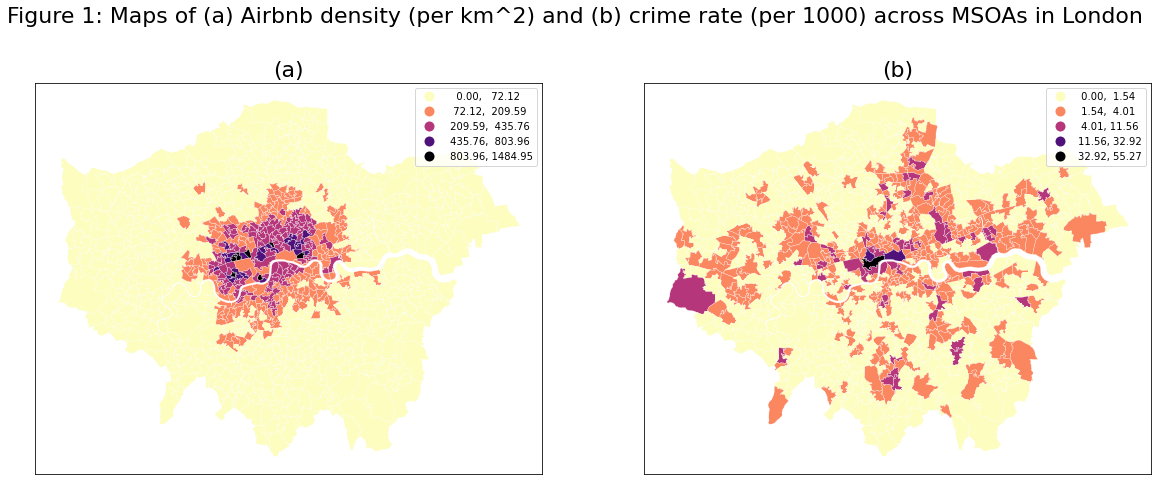

In [70]:
# create figure 
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
msoas_final.plot(ax= axes[0], column="airbnb_per_km_sq", cmap='magma_r', linewidth=0.25, edgecolor='white', scheme="fisher_jenks", legend=True)
msoas_final.plot(ax= axes[1], column="crime_per_1000", cmap='magma_r', linewidth=0.25, edgecolor='white', scheme="fisher_jenks", legend=True)
fig.suptitle('Figure 1: Maps of (a) Airbnb density (per km^2) and (b) crime rate (per 1000) across MSOAs in London', fontsize=22)
axes[0].set_title("(a)", fontsize = 22)
axes[1].set_title("(b)", fontsize = 22)
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[1].set_xticks([])
axes[1].set_yticks([])
plt.subplots_adjust(top=1.08)
fig.savefig("map1.png")

## Multiple Linear Regression

Multiple Linear Rigression has first been conducted to determine the global values of the model. The results have not been included in the final output of the policy briefing.  
We start with the calculation of VIF for variable selection.

In [71]:
# calculating VIF
# This function is adjusted from: https://stackoverflow.com/a/51329496/4667568
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant

def drop_column_using_vif_(df, thresh=5):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param thresh: (default 5) the threshould VIF value. If the VIF of a variable is greater than thresh, it should be removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True: # while true is true
        # adding a constatnt item to the data. add_constant is a function from statsmodels (see the import above)
        df_with_const = add_constant(df) # take a dataframe and add an initial column 'const' with 1.0 in it

        # Pandas Series is a one-dimensional labeled array capable of holding data of any type (basically a column)
        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        # drop the const
        vif_df = vif_df.drop('const')
        
        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        # If there are multiple variabels with VIF>thresh, only one of them is removed. This is because we want to keep as many variables as possible
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df

In [72]:
msoas_final_independent = drop_column_using_vif_(msoas_final[["airbnb_per_km_sq", "population_density", "unemployment_rate", "median_household_income", "qualification_low_percentage", "ethnic_diversity"]])

In [73]:
msoas_final_independent.columns

Index(['airbnb_per_km_sq', 'population_density', 'unemployment_rate',
       'median_household_income', 'qualification_low_percentage',
       'ethnic_diversity'],
      dtype='object')

There are no columns which are dropped based on the VIF score - we will proceed 

In [74]:
model_airbnb_count = sm.formula.ols('crime_per_1000 ~ airbnb_per_km_sq + population_density + unemployment_rate + median_household_income + qualification_low_percentage + ethnic_diversity', msoas_final).fit()
model_airbnb_count.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         crime_per_1000   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                  0.112
Method:                 Least Squares   F-statistic:                     21.72
Date:                Wed, 18 Jan 2023   Prob (F-statistic):           4.75e-24
Time:                        09:49:43   Log-Likelihood:                -2226.6
No. Observations:                 983   AIC:                             4467.
Df Residuals:                     976   BIC:                             4501.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        4.2317      1.045      4.051      0.000       2.182       6.282
airbnb_per_km_sq                 0.0055      0.001      7.947      0.000       0.004       0.007
population_density              -0.0157      0.003     -6.250      0.000      -0.021      -0.011
unemployment_rate                0.2161      0.052      4.191      0.000       0.115       0.317
median_household_income      -3.105e-05   1.44e-05     -2.160      0.031   -5.93e-05   -2.84e-06
qualification_low_percentage    -0.0410      0.012     -3.542      0.000      -0.064      -0.018
ethnic_diversity                -0.1880      0.800     -0.235      0.814      -1.757       1.381
==============================================================================
Omnibus:                     1868.865   Durbin-Watson:                   1.900
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3028066.809
Skew:                          13.523   Prob(JB):                         0.00
Kurtosis:                     273.553   Cond. No.                     5.20e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.2e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Geographic Weighted Regression
The following code for GWR has been adapted from the following resource. Please see the source for more information on conducting GWR with the mgwr package in London.  

Oshan, T., Li, Z., Kang, W., Wolf, L. and Fotheringham, A. (2019) ‘mgwr: A Python Implementation of Multiscale Geographically Weighted Regression for Investigating Process Spatial Heterogeneity and Scale’, ISPRS International Journal of Geo-Information, 8(6), p. 269. doi:10.3390/ijgi8060269.

In [75]:
# create column for centroid (Easting (X) and Northing (Y)) of each MSOA
msoas_final["X"] = msoas_final.centroid.map(lambda p: p.x)
msoas_final["Y"] = msoas_final.centroid.map(lambda p: p.y)

In [76]:
# define the variables and geographic coordinates
l_y = msoas_final["crime_per_1000"].values.reshape((-1, 1)) # values of the dependent variable
dep_con = ["airbnb_per_km_sq", "population_density", "unemployment_rate", "median_household_income", "qualification_low_percentage", "ethnic_diversity"] # columns of the independent and control variables
l_X = msoas_final[dep_con].values # values of the independent and control variables based on columns 
u = msoas_final['X']  
v = msoas_final['Y']
l_coords = list(zip(u, v)) # the geographic locations of regression points 

Parameter we need to set for conducting GWR (Oshan et al., 2019)
- kernel function and type
function: set to the default bi-square kernel as it accounts for the issue of distant observations remaining their influence, and allows for intuitive interpretation
type: adaptive kernel - adapts depending on the varying spatial distribution
- bandwidth selection
we will select the bandwidth by optimizing a model fit criterion

In [77]:
# instantiate bandwidth selection object (model inputs and geographic coordinates)
gwr_selector = Sel_BW(l_coords, l_y, l_X)
# selecting the bandwidth based on default golden section search using AICc criterion
gwr_bw = gwr_selector.search()
print(gwr_bw)

140.0


In [78]:
# Calibration of a GWR model
gwr_model = GWR(l_coords, l_y, l_X, gwr_bw)
gwr_results = gwr_model.fit()
print(gwr_results.resid_ss)

3336.02711927735


We have produced some plots to understand the outputs

<AxesSubplot:>

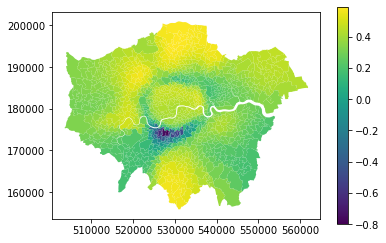

In [79]:
msoas_final['R2'] = gwr_results.localR2
msoas_final.plot('R2', legend = True)

In [80]:
msoas_final['R2'].describe()

count    983.000000
mean       0.342183
std        0.173246
min       -0.800870
25%        0.272648
50%        0.370125
75%        0.450702
max        0.592877
Name: R2, dtype: float64

<AxesSubplot:>

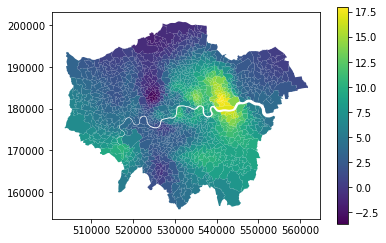

In [81]:
# the intercept of intercepts of the gwr model
msoas_final['gwr_intercept'] = gwr_results.params[:, 0]
msoas_final.plot('gwr_intercept', legend = True)

In [82]:
# store the coefficients of airbnb density
msoas_final["gwr_airbnb"] = gwr_results.params[:, 1]

In [83]:
# manually set significance level (alpha) for the visualisation of hypothesis tests for significance of parameter estimates
filter_t = gwr_results.filter_tvals(alpha=0.05)
msoas_final['gwr_airbnb_sig'] = filter_t[:,1]

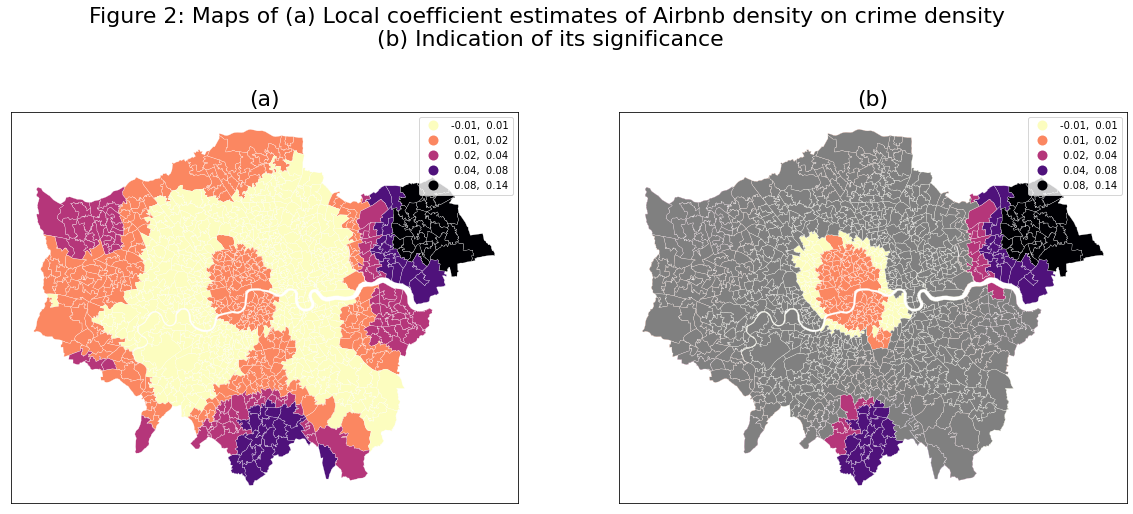

In [84]:
# create figure 
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
msoas_final.plot(ax= axes[0], column="gwr_airbnb", cmap='magma_r', linewidth=0.25, edgecolor='white', scheme="fisher_jenks", legend=True)
msoas_final.plot(ax= axes[1], column="gwr_airbnb", cmap='magma_r', linewidth=0.25, edgecolor='white', scheme="fisher_jenks", legend=True)
msoas_final[filter_t[:,1] == 0].plot(color='grey', ax=axes[1], edgecolor = 'white', linewidth=.25)
fig.suptitle('Figure 2: Maps of (a) Local coefficient estimates of Airbnb density on crime density \n(b) Indication of its significance', fontsize=22)
axes[0].set_title("(a)", fontsize = 22)
axes[1].set_title("(b)", fontsize = 22)
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[1].set_xticks([])
axes[1].set_yticks([])
plt.subplots_adjust(top=1)
fig.savefig("map2.png")